<a href="https://githubtocolab.com/BorjaRequena/Neural-Network-Course/blob/master/nbs/course/applications-nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

::: {.callout-note}

In this notebook we make extensive use of transfer learning, a technique that we will explain in a couple of lessons.

Furthermore, we use the [fastai](https://docs.fast.ai/) [@fastai] library to download the data for the different tasks and easily train our models.

::: 

In [ ]:
#| hide
# Uncomment and run this cell if using collab
# !pip install -U fastai
# !pip install -U scipy

In [ ]:
#| hide
from fastai.text.all import *

# Introduction

Natural language processing (NLP) is the field of machine learning that handles the interaction with spoken or written language as us, humans, use it. Hence, it is most likely the field that makes more notable the advances in artificial intelligence, as it is our interface with modern machines in our daily lifes. It does not matter that our phone can run the most advanced algorithms if, when we ask for a simple thing, it does not understand us at all or it replies with 70s-robotic-voice. On the other hand, even if the internal processing is not the most advanced, having a smooth interaction makes us feel that whatever artificial intelligence lies within is much more advanced. 

NLP covers many aspects, featuring speech recognition (voice to text), semantic analysis, text generation and text to speech, among others. Here, we will mainly focus on text processing to illustrate a few representative tasks. 

While computer vision has been a long established field overcoming human performance, the advances in NLP are much more recent. Contributions in the last few years with algorithms such as [ULMFiT](https://arxiv.org/abs/1801.06146), predecessor of the GPT series ([GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) and [GPT-3](https://arxiv.org/pdf/2005.14165.pdf)) have brought the field of NLP a step forward. The main idea behind these works consist on, first, training a generative model that 'understands' the language involved in the task without any specific goal. Then, we can leverage its knowledge to tackle the specific task at hand. In some cases, we do not even need to train our model any further despite it not being specifically trained for the task!

We will dive deeper into generative modeling and the current state of the art in the last lecture of the course :D

# Language modeling

Language models are generative algorithms used to create text given a context. Intuitively, these models learn to reproduce the content they read. They have countless wonderful applications, such as this [Trump tweet generator](https://filiph.github.io/markov/), which writes tweets as if it was Donald Trump.

We will illustrate the process of language modeling writing movie reviews using the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/). We generate text by asking the model to infer what the next word will be given a text fragment. This way, providing the model with a starting point, we add the predicted word to the text and, recursively, repeat the whole process to write a full text.  

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

Just like in the computer vision examples, we will leverage transfer learning. As starting point, we take a generative model that has been trained with the [text data from wikipedia](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/), which already comes with great knowledge of our world. Such a pre-trained model is highly versatile as, in our application case, movies can feature historical phenomena or specific events and characters that a model with the knowledge from wikipedia will already know. For instance, when the name of an actor appears in a review, the model will already know who it is and other things it has done or, even more, the model will infer the content of the movie out of certain featured names.

:::

Let's have a look at the data!  

In [ ]:
#| code-fold: true
path = untar_data(URLs.IMDB)
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls_lm = DataBlock(blocks=TextBlock.from_folder(path, is_lm=True),
                   get_items=get_imdb, splitter=RandomSplitter(0.1)
                   ).dataloaders(path, path=path, bs=128, seq_len=80)

dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj yes , it ignores most of xxmaj europe and the rest of the worlds contributions , but for what it is , it 's just lovely . \n\n xxmaj it 's an introduction to the art of cinematography in xxmaj american movies , with clips and comments from the greats about xxmaj american film from birth till 1990 or so , when it was made . xxmaj some of the cinematographers are humble and self - effacing ,","xxmaj yes , it ignores most of xxmaj europe and the rest of the worlds contributions , but for what it is , it 's just lovely . \n\n xxmaj it 's an introduction to the art of cinematography in xxmaj american movies , with clips and comments from the greats about xxmaj american film from birth till 1990 or so , when it was made . xxmaj some of the cinematographers are humble and self - effacing , some"
1,"and requires contemplation . xxbos xxmaj i 'm usually the guy telling other reviewers they 're being too harsh . xxmaj but i found myself grimly forcing myself to sit through this travesty to the bitter end , for no better reason than xxmaj i 'm a stupid , masochistic completist xxunk this series . xxmaj what a bitter caricature of a xxunk ; i wish i had n't noticed it was on . \n\n xxmaj first of all ,","requires contemplation . xxbos xxmaj i 'm usually the guy telling other reviewers they 're being too harsh . xxmaj but i found myself grimly forcing myself to sit through this travesty to the bitter end , for no better reason than xxmaj i 'm a stupid , masochistic completist xxunk this series . xxmaj what a bitter caricature of a xxunk ; i wish i had n't noticed it was on . \n\n xxmaj first of all , the"


Notice that the text is tokenized including special symbols such as `xxbos`, indicating the beginning of sentence, `xxmaj` indicating that the next word starts with a capital letter, and so on. Truth is that the model does not understand words as they are, but rather it uses a representation of the words in a high dimensional mathematical space. 

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

Looking at the data, we see that the text is split into fragments that are shifted by one word between one another. This is because the target of the text on the left is its next word, that is, the text on the right. We use a recurrent neural network (RNN) to which the text is recursivelly passed word by word and, at every step, the target is the corresponding word on the right. Using the pre-traiend wikipedia RNN, we already have an embedding representing most of the English words and the network knows how to relate them. We just need to fine-tune the RNN in order to specialize it in the movie review context.

Notice that training these models takes much longer than training the computer vision or tabular data ones. This is because of the nature of the RNN architecture, that loops over each word of the text and... well, Python does not like loops :)

:::

Let's train! 

In [ ]:
#| code-fold: true
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()
learn.fine_tune(10, base_lr=2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.141006,4.018666,0.290516,55.626865,11:10


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.806848,3.775722,0.312664,43.628998,10:39
1,3.769517,3.749914,0.314977,42.517441,10:32
2,3.728264,3.719217,0.319099,41.232098,10:31
3,3.677289,3.685531,0.323200,39.866291,10:32
4,3.614626,3.654452,0.327608,38.646320,10:32
5,3.552478,3.628734,0.330706,37.665115,10:35
6,3.487630,3.608381,0.333443,36.906254,10:38
7,3.422164,3.594230,0.335815,36.387676,10:36
8,3.359136,3.591810,0.336942,36.299736,10:41
9,3.309520,3.595514,0.336873,36.434418,10:36


The model correctly predicts the next word more than a third of the times. The number may not be outstanding compared with the accuracies that we have obtained in the computer vision tasks, but think about its meaning: the model correctly infers what the next word of any arbitrary review will be one out of every three guesses. 

Let's now ask it to make some movie reviews for us. We provide it with the start of a sentence and see where it goes. Let's start with 'I liked this movie because':

In [ ]:
#| code-fold: true
n_words = 50
stem = "I liked this movie because"
pred = learn.predict(stem, n_words, temperature=0.75)
print(pred)

i liked this movie because it was one of the best thrillers of the 80 's . The acting was above average and the plot was much more interesting . 

 There are cuts to this movie that make it seem like it was shot with a camcorder , but i think that


See what happens with 'Such a terrible movie should never':

In [ ]:
#| code-fold: true
stem = "Such a terrible movie should never"
pred = learn.predict(stem, n_words, temperature=0.75)
print(pred)

Such a terrible movie should never have been made . The director of this film , Paul Anderson , should be fired . So there are some OTHER reasons to waste any time on this flick . i have to disagree with the other comments . If you want to


These are some hilarious reviews! All of them make sense and are more or less coherent. For instance, when we provide the model with a positive beginning, 'I liked this movie because', the movie review tries to explain the reasons why it was so good. On the other hand, when we provide a negative starting point, 'Such a terrible movie should never', the review rips the movie beefing its director. 

Notice that, in these two reviews, the model has included names such as Paul Anderson (despite him being an actor and not a director), concepts like camcorder or thriller of the 80's and it has even emphasized the word 'OTHER' with capital letters. 

The dataset is made out of highly polarized movie reviews ando so the model has an easy time writing positive or negative reviews. Let's see where it takes us whenever we provide it with an open start like 'This movie about':  

In [ ]:
#| code-fold: true
stem = "This movie about "
pred = learn.predict(stem, n_words, temperature=0.75)
print(pred)

This movie about a number of things that do n't happen to us , most of them are not exciting . The main problem with the movie is the fact that it is more about life than about the life of others . The main character , Bayliss , is


In [ ]:
#| code-fold: true
stem = "This movie about "
pred = learn.predict(stem, n_words, temperature=0.75)
print(pred)

This movie about a small town , Iowa , is about a young man ( bill Paxton ) who is right about to go to school with a girl he met and he falls in love with her ( deborah Murray ) . She is also a photographer ,


With the same starting point, the first review is negative straight away, but the second remains neutral for the limited size that we have provided. 

Now that we have this powerful language model, we can use it knowledge to address other tasks involving movie reviews, so we will save the main body of the model for later.

In [ ]:
#| code-fold: true
learn.save_encoder("imdb_encoder")

# Text classification

One of the most extended applications of NLP is text classification, which consists on assigning categories to pieces of text. This is highly related with "understanding" texts in artificial intelligence pipelines and data mining. For instance, we can use these classifiers to automatically sort scientific publications into their respective fields, e.g. condensed matter, neurology, ..., and similar tasks. We can also use these models to find whether customer feedback is positive or negative at a large scale, separate fake news from real ones, or even tell the native language of the writer from a text in English.

In order to illustrate a case, we will continue with the same application example as before, leveraging the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/), to assess whether movie reviews are positive or negative. Notice that, despite using the same dataset, the task is completely different. During the training of the langauge model, the target was the same bit of thext shifted by one word. Now, the target is a label indicating whether the review is positive or negative, as we see below.

In [ ]:
#| code-fold: true
path = untar_data(URLs.IMDB)

dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab), CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path, path=path, bs=128, seq_len=72)

dls_clas.show_batch(max_n=5)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love story is an interesting one , however . xxmaj kate xxmaj winslett is wonderful as xxmaj rose , an aristocratic young lady betrothed by xxmaj cal ( billy xxmaj zane ) . xxmaj early on the voyage xxmaj rose meets xxmaj jack ( leonardo dicaprio ) , a lower class artist on his way to xxmaj america after winning his ticket aboard xxmaj titanic in a poker game . xxmaj if he wants something , he goes and gets it",pos
2,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",neg
3,"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj mexican , obviously ) , his good will towards his fellow man backfires . xxmaj in that case , it was n't too hard to predict that he was about to have a handful of angry hoodlums , but i like that the movie suggests that things like that should n't be ignored . xxmaj i 'm reminded of the episode of xxmaj michael xxmaj moore 's brilliant xxmaj the xxmaj awful xxmaj truth , when they had a man",pos
4,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the oddest possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is innate , contained within the characters and the setting and the plot … which is highly believable to boot . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",pos


Let's take the previous language model that we had trained to generate movie reviews, which knows quite a lot of the world thanks to wikipedia, and quite a bit more of movies, as starting point for our classifier.

::: {.callout-note collapse="true"}
## Expand to learn about the training procedure

Given the language model, we now add a fully connected layer at the back. The language model acts as feature extractor of the text, which feeds a dense classifier that outputs the probability of belonging to each class: positive or negative. Just as in computer vision, we start by freezing the pre-trained part of the model and then we proceed to unfreeze it once the training has advanced. In this case, however, we will gradually unfreeze the different layers of the model, from back to front, rather than unfreezing it all at once. Additionally, we will be using discriminative learning rates for the whole process.<br><br>This process of taking a generic language model (wikipedia), fine-tunning it to our task (movie reviews) and, finally, using it as a classifier is the core of [ULMFiT](https://arxiv.org/abs/1801.06146), as previously hinted.

:::

Let's train!

In [ ]:
#| code-fold: true
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()
learn = learn.load_encoder('imdb_encoder')

learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.356537,0.200132,0.920920,00:25


In [ ]:
#| code-fold: true
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.277847,0.178657,0.931400,00:30


In [ ]:
#| code-fold: true
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.211942,0.158949,0.941560,00:38


In [ ]:
#| code-fold: true
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.181801,0.154084,0.942280,00:46
1,0.159143,0.157385,0.944000,00:47


We reach an accuracy of ~94% in less than 4 minutes of training. This is mainly thanks to using our pre-trained language model as a feature extractor, which can extract rich information from the movie reviews to create a wonderful classifier. 

Let's see some examples.

In [ ]:
#| code-fold: true
learn.show_results(max_n=4)

,text,category,category_
0,"xxbos xxmaj there 's a sign on xxmaj the xxmaj lost xxmaj highway that says : \n\n * major xxup spoilers xxup ahead * \n\n ( but you already knew that , did n't you ? ) \n\n xxmaj since there 's a great deal of people that apparently did not get the point of this movie , xxmaj i 'd like to contribute my interpretation of why the plot makes perfect sense . xxmaj as others have pointed out , one single viewing of this movie is not sufficient . xxmaj if you have the xxup dvd of xxup md , you can "" cheat "" by looking at xxmaj david xxmaj lynch 's "" top 10 xxmaj hints to xxmaj unlocking xxup md "" ( but only upon second or third viewing , please . ) ;) \n\n xxmaj first of all , xxmaj mulholland xxmaj drive is",pos,pos
1,"xxbos xxmaj back in the mid / late 80s , an xxup oav anime by title of "" bubblegum xxmaj crisis "" ( which i think is a military slang term for when technical equipment goes haywire ) made its debut on video , taking inspiration from "" blade xxmaj runner "" , "" the xxmaj terminator "" and maybe even "" robocop "" , with a little dash of xxmaj batman / xxmaj bruce xxmaj wayne - xxmaj iron xxmaj man / xxmaj tony xxmaj stark and xxmaj charlie 's xxmaj angel 's girl power thrown in for good measure . 8 episodes long , the overall story was that in 21st century xxmaj tokyo , xxmaj japan , year xxunk - xxunk , living machines called xxmaj boomers were doing manual labor and sometimes cause problems . a special , xxup swat like branch of law enforcers ,",pos,pos
2,"xxbos xxmaj if anyone ever assembles a compendium on modern xxmaj american horror that is truly worth it 's salt , there will * have * to be an entry for xxup sf xxmaj brownrigg 's xxunk xxunk in xxmaj asylum xxmaj horror . xxmaj every time i watch this movie i am impressed by the complete economy of the film , from the compact , totally self - contained plot with a puzzling beginning and an all too horrible ending , the engaging performances by what was essentially a group of non - professional actors , and a xxunk sense of dread and claustrophobia that effectively consumes the xxunk with a certain inevitability which is all the more terrifying because the viewers know what is going on long before the xxunk ] , with the only question being when are they going to wake up & smell the coffee",pos,pos
3,"xxbos xxmaj tony xxmaj hawk 's xxmaj pro xxmaj skater 2x , is n't much different at all from the previous games ( excluding xxmaj tony xxmaj hawk 3 ) . xxmaj the only thing new that is featured in xxmaj tony xxmaj hawk 's xxmaj pro xxmaj skater 2x , is the new selection of levels , and tweaked out graphics . xxmaj tony xxmaj hawk 's xxmaj pro xxmaj skater 2x offers a new career mode , and that is the 2x career . xxmaj the 2x career is basically xxmaj tony xxmaj hawk 1 career , because there is only about five challenges per level . xxmaj if you missed xxmaj tony xxmaj hawk 1 and 2 , i suggest that you buy xxmaj tony xxmaj hawk 's xxmaj pro xxmaj skater 2x , but if you have played the first two games , you should still",pos,pos


We can even get the classifier to tell whether our reviews are positive or negative.

In [ ]:
review = "This movie is fucking awful"
learn.predict(review)

('neg', TensorText(0), TensorText([0.9409, 0.0591]))

In [ ]:
review = "Such a wonderful movie!!!"
learn.predict(review)

('pos', TensorText(1), TensorText([9.0573e-04, 9.9909e-01]))

From left to right, we see the category 'neg' or 'pos', its numerical equivalent (0 or 1) and the tensor telling the machine confidence for each class. In both cases, the model is pretty certain of the class it is predicting: 0.941 negative and 0.999 positive for each review, respectively. Let's try with something that is less obvious.

In [ ]:
review = ("At first, this movie looked great and eganging. I was having a great time. Nonetheless,"+
          " the last half turned out to be complete boring and worthless.")
learn.predict(review)

('neg', TensorText(0), TensorText([0.9985, 0.0015]))

Here, we introduced a turning point in the review and the model got it pretty well. Let's try with something a bit more neutral or ambiguous.

In [ ]:
review = "The movie is about a penguin's life. I guess it is somewhat informative, at least."
learn.predict(review)

('pos', TensorText(1), TensorText([0.2826, 0.7174]))

We can see that in this last case, the model is much less confident about this being a positive review and the truth is that it can be interpreted in both ways. The movie can fall in the "not bad" category and we say that it is somewhat informative. However, it could also be that the movie is terrible to watch but that, at least, we get to learn something.

# Other natural language applications

As previously mentioned, NLP covers a massive range of applications. Directly related with what we've done so far, we could do some text regression tasks in which we aim to predict, for instance, a movie score out of the review. The process would be analogous to fine-tuning the text classifier.

However, there are other completely different tasks that we can tackle. For example, we can translate a text to a different language, we can summarize it, we can extract a conceptual graph, etc.

# Sequence modeling

So far, we have seen computer vision applications exclusively involving images, and natural language processing applications involving only text. However, there are many tasks that involve various kinds of data at once. For example, we may be interested in writing captions that describe images. This is a language modeling task that takes an image as starting point. Conversely, we may be interested in generating images given a description, which is a computer vision generative task with a text as starting point. 

This is performed by considering the data as a sequence of pieces of information all together. Just like the tokenization that we have performed for the text processing, we can come up with ways to tokenize our images. Combining both approaches, our models can then process the series of tokens regardless of their origin. There have recently been huge advances in this field. For example, [flamingo](https://www.deepmind.com/blog/tackling-multiple-tasks-with-a-single-visual-language-model) is a chatbot that can process images, seamlesly integrating text and images in a conversation. Perhaps even more surprisingly, diffusion models such as [DALLE-E](https://openai.com/dall-e-2/) can create high resolution images from arbitrary prompts.

We can download and play around with one of these models! For example, you can follow [this tutorial](https://realpython.com/generate-images-with-dalle-openai-api/) to use the OpenAI API or [this tutorial](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb) to use the [huggingface](https://huggingface.co/) stable diffusion models.

In [ ]:
#| hide
import io
import openai
from PIL import Image
from base64 import b64decode

openai.api_key = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [ ]:
#| code-fold: true
def generate_image(prompt):
    "Generates an image with the DALL-E2 API"
    response = openai.Image.create(
        prompt=prompt, n=1, size="1024x1024", response_format="b64_json"
    )
    img = b64decode(response['data'][0]['b64_json'])
    return Image.open(io.BytesIO(img))

You can use [these references](https://lexica.art/) to draw inspiration for better prompts!

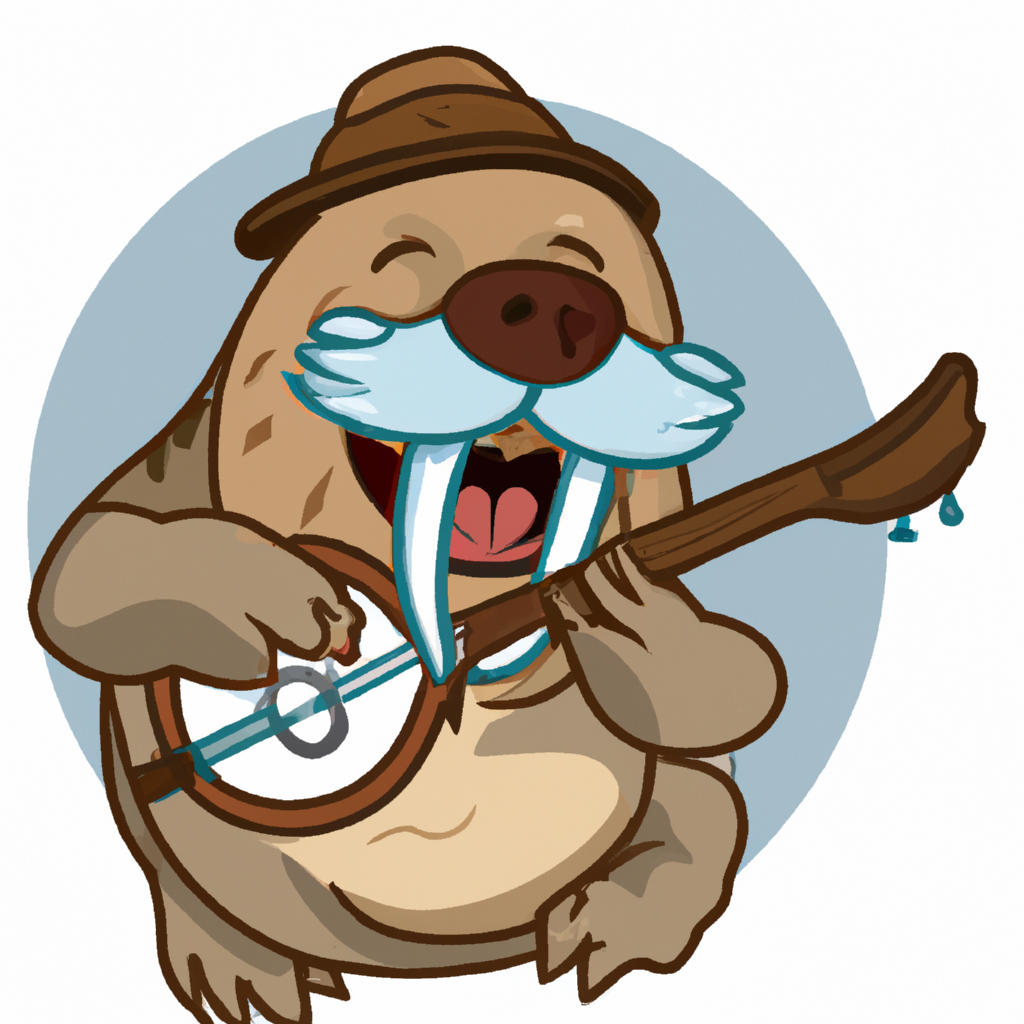

In [ ]:
description = "Cute and adorable walrus playing the banjo"
generate_image(description)

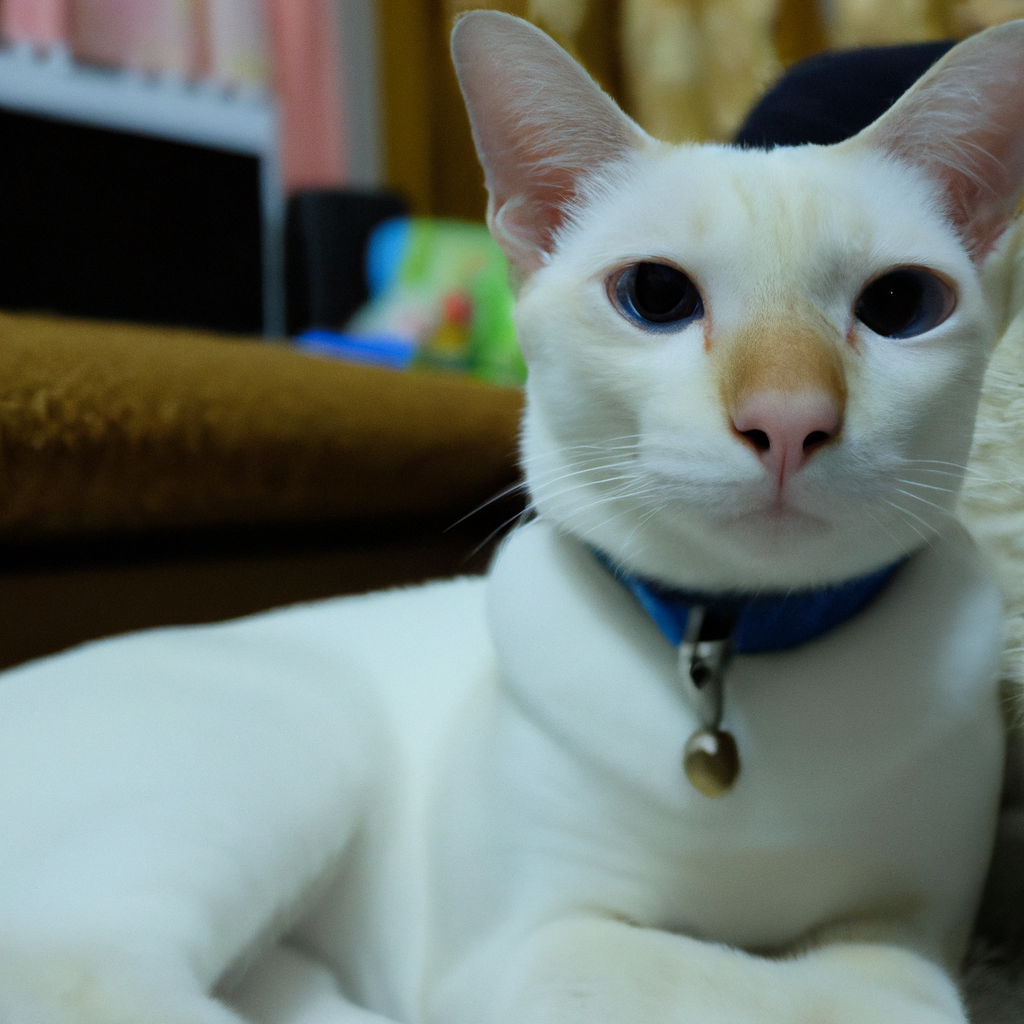

In [ ]:
description = "a white siamese cat"
generate_image(description)